# 0. Setup

## 0.1. Imports

In [356]:
import os
import random
import torch
import torch.optim as optim

from part import Part
from graph import Graph

from torch_geometric.data import Data
from torch_geometric.nn import GCNConv, GAE
from torch_geometric.loader import DataLoader
from torch.utils.data import Dataset

from graph_loader import load_graphs
from gensim.models import Word2Vec
from itertools import combinations
from typing import Set

## 0.2. Hyperparameters

In [375]:
SEED = 0
random.seed(SEED)

example_graph = 2

# Random Walks:
num_walks = 25
walk_length = 7

# Embedding model:
embedding_vector_size=16    # Size of the embedding vector
window=5                    # Context window size --> Wie viele Wörter außenherum werden beachtet? --> ca. 5, da Durchscnittliche größe der Graphen (Entscheidung von 2 auf 5 machte Unterschied)
min_count=1                 # Minimum occurrences of a node in the walks to include it in the vocabulary
sg=1                        # Use Skip-Gram (sg=1) instead of CBOW (sg=0)
workers=4                   # Number of CPU threads to use
embedding_model_epochs=50   # Number of training epochs
edge_threshold=0.5          # Threshold when an edge might be added

# GAE model:
learning_rate = 0.01
input_dim = embedding_vector_size          # Dimension of node embeddings (from Word2Vec)
hidden_dim = 32
latent_dim = 16
gae_epochs = 100

# 1 Process Training Data

## 1.1 Helper Functions

In [312]:
def create_part_list(graph):
    part_list = []
    nodes = graph.get_nodes()
    for node in nodes:
        part_list.append((node.get_id(), node.get_part().get_part_id()))
    return part_list

In [313]:
def create_edge_list(graph):
    edge_set = set()
    edges = graph.get_edges()
    for node, connected_nodes in edges.items():
        for connected_node in connected_nodes:

            # Store edges by node_ID and part_ID + node_ID and part_ID or source and target
            # Make sure each edge is only stored once (unidirectionally)
            edge = tuple(sorted((
                (node.get_id(), int(node.get_part().get_part_id())),
                (connected_node.get_id(), int(connected_node.get_part().get_part_id()))
            )))
            edge_set.add(edge)

    return list(edge_set)


In [314]:
def prepare_graph_data(graph_dataset):
    part_list_dict = {}
    edge_list_dict = {}

    for index, graph in enumerate(graph_dataset):
        part_list_dict[index] = create_part_list(graph)
        edge_list_dict[index] = create_edge_list(graph)

    # Sort the lists within the dictionaries
    for key in part_list_dict.keys():
        part_list_dict[key] = sorted(part_list_dict[key], key=lambda x: x[0])  # Sort by NodeID

    for key in edge_list_dict.keys():
        edge_list_dict[key] = sorted(edge_list_dict[key], key=lambda x: (x[0][0], x[1][0]))  # Sort edges by source and target

    return part_list_dict, edge_list_dict



## 1.2 Prepare Datasets

### 1.2.1 Graph Dataset

In [357]:
class GraphDataset(Dataset):
    def __init__(self, file_path: str, train=False, validation=False, test=False, seed=42):
        if not os.path.exists(file_path):
            raise FileNotFoundError(f"Dataset file not found at {file_path}")

        self.graphs = load_graphs(file_path)

        if sum([train, validation, test]) != 1:
            raise ValueError("Exactly one of 'train', 'validation', or 'test' must be True.")

    def __getitem__(self, idx):
        graph = self.graphs[idx]
        return graph

### 1.2.2 Read Datasets

In [338]:
training_set = GraphDataset("data/graphs.dat", train = True, seed=SEED)
validation_set = GraphDataset("data/graphs.dat", validation = True, seed=SEED)
testing_set = GraphDataset("data/graphs.dat", test = True, seed=SEED)

### 1.2.3 Prepare Part and Edge Data for all graphs

In [317]:
"""
Dictionaries of key: graph-index / graph-id and lists of parts
"""
graph_parts_dict, graph_edge_dict = prepare_graph_data(training_set)

print(graph_parts_dict[0])


[(0, '1621'), (1, '58'), (2, '58'), (3, '58'), (4, '58')]


## 1.3. Create Embeddings

Embeddings represent features of a node e.g. 16 features of Part 1 are 16 Embedding values

### 1.3.1. Random Walk Embeddings

In [318]:
def generate_random_walks_single_graph(edges):
    """
    Generate random walks for a single graph.

    Parameters:
        edges (list): Edge list for a single graph.
        num_walks (int): Number of random walks to generate per node.
        walk_length (int): Length of each random walk.

    Returns:
        list: A list of random walks, where each walk is a list of PartIDs.
    """
    # TODO in das ReadMe: Hier fraglich of random-walks funktionieren, da viel hin und her wegen non-cyclical
    # TODO Maximilian: Context


    walks = []
    graph = {}

    # Build adjacency list
    for edge in edges:
        node1, node2 = edge[0][1], edge[1][1]  # Extract PartIDs
        graph.setdefault(node1, []).append(node2)
        graph.setdefault(node2, []).append(node1)

    # Perform random walks
    for _ in range(num_walks):
        for node in graph.keys():
            walk = [node]  # Start the walk with the current node
            while len(walk) < walk_length:
                cur = walk[-1]  # Get the last node in the walk
                if cur in graph:
                    walk.append(random.choice(graph[cur]))  # Add a random neighbor
                else:
                    break
            walks.append(walk)  # Add the walk to the list of walks

    return walks

In [319]:
# Generate Random Walks for all graphs:
# execution Dauer: ca. 13 Sekunden (training), ca. 12 Sekunden (testing)

random_walks = {}
for index, graph in enumerate(training_set):
    random_walks[index] = generate_random_walks_single_graph(graph_edge_dict[index])
print(random_walks[example_graph])

[[186, 11, 175, 11, 175, 11, 175], [10, 186, 10, 186, 10, 186, 11], [11, 186, 11, 186, 11, 175, 11], [175, 11, 186, 11, 175, 11, 186], [186, 11, 186, 10, 186, 11, 186], [10, 186, 11, 175, 11, 175, 11], [11, 175, 11, 175, 11, 175, 11], [175, 11, 186, 10, 186, 11, 175], [186, 11, 175, 11, 175, 11, 186], [10, 186, 11, 186, 11, 186, 11], [11, 175, 11, 186, 11, 186, 11], [175, 11, 175, 11, 175, 11, 175], [186, 10, 186, 11, 186, 10, 186], [10, 186, 10, 186, 11, 175, 11], [11, 175, 11, 175, 11, 186, 11], [175, 11, 175, 11, 175, 11, 175], [186, 11, 175, 11, 186, 11, 175], [10, 186, 11, 186, 11, 175, 11], [11, 186, 11, 175, 11, 186, 10], [175, 11, 175, 11, 186, 10, 186], [186, 11, 175, 11, 175, 11, 175], [10, 186, 10, 186, 11, 186, 11], [11, 186, 11, 175, 11, 186, 10], [175, 11, 175, 11, 186, 11, 175], [186, 10, 186, 11, 186, 10, 186], [10, 186, 10, 186, 11, 175, 11], [11, 175, 11, 175, 11, 186, 11], [175, 11, 186, 11, 186, 10, 186], [186, 11, 186, 11, 186, 11, 175], [10, 186, 11, 186, 11, 186,

### 1.3.2. Train Word2Vec Model with Random Walk Embeddings

In [320]:
"""
    flattening Dauer: instant
    training Dauer pro Epoche: 5s
"""
# Flattening the random walks to be able to train Embedding model on them:
# flat_random_walks Länge: 1.310.240
flat_random_walks = [walk for walks in random_walks.values() for walk in walks]

# Training embedding model:
word2vec_model = Word2Vec(
    sentences=flat_random_walks,
    vector_size=embedding_vector_size,
    window=window,
    min_count=min_count,
    sg=sg,
    workers=workers,
    epochs=embedding_model_epochs
)
word2vec_model.save("node_embeddings.model")
print("Embedding model saved \n")

Embedding model saved 



## 1.4. Prepare Training Data

In [323]:
# Create one parts-torch, one edge-torch and one label-torch for each graph:
all_graph_data = []

for graph_id in graph_parts_dict.keys():

    # Retrieve parts and edges for the current graph
    graph_parts = graph_parts_dict[graph_id]
    graph_edges = graph_edge_dict[graph_id]

    # 1. Extract Parts Features:
    parts_list = []
    for part in graph_parts:
        embedding = word2vec_model.wv[int(part[1])]
        parts_list.append(embedding)
    parts = torch.tensor(parts_list, dtype=torch.float)

    # 2. Extract Edge Features:
    edge_index_list = []
    for edge in graph_edges:
        source_node = edge[0][0]
        target_node = edge[1][0]
        edge_index_list.append((source_node, target_node))
    edge_index = torch.tensor(edge_index_list, dtype=torch.long).t().contiguous()

    # 3. Extract Edge Labels:
    pos_edge_label = torch.ones(edge_index.size(1))  # Positive edges -> Exist in the graph

    # 4. Create Data Object for the Current Graph:
    single_graph_data = Data(x=parts, edge_index=edge_index, pos_edge_label=pos_edge_label)
    all_graph_data.append(single_graph_data)

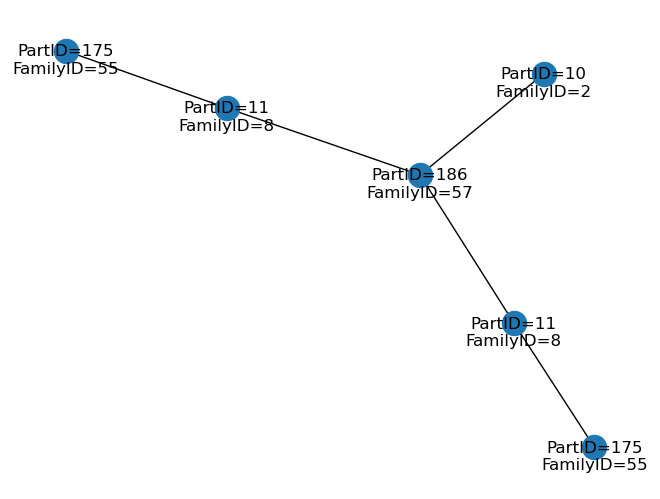

Data(x=[6, 16], edge_index=[2, 5], pos_edge_label=[5])
tensor([[-1.8880, -0.2448,  2.7348,  2.1951,  3.3350,  1.4245, -0.7450, -0.2479,
         -1.0782,  0.3293, -0.7487, -0.4041,  1.9187, -0.0150,  2.0633, -0.2734],
        [-0.7735,  0.4990,  0.4769,  0.1346,  1.3942,  2.3561,  0.8379,  0.8478,
         -0.0293,  0.0754, -1.3937,  0.0226,  2.5194, -2.2089, -1.7548,  0.0672],
        [ 0.2798,  0.8104,  0.3692, -0.3605,  0.8933, -0.1720, -0.6786, -0.9534,
         -0.2215,  0.2947, -0.2533, -0.1949,  0.4417,  0.2810,  0.0808, -0.0796],
        [ 0.2798,  0.8104,  0.3692, -0.3605,  0.8933, -0.1720, -0.6786, -0.9534,
         -0.2215,  0.2947, -0.2533, -0.1949,  0.4417,  0.2810,  0.0808, -0.0796],
        [ 0.3058,  1.1059,  0.5098, -0.4539,  1.1662, -0.0644, -0.7410, -1.1496,
         -0.4955,  0.3146,  0.0734, -0.2136,  0.6962,  0.2228,  0.6481,  0.2754],
        [ 0.3058,  1.1059,  0.5098, -0.4539,  1.1662, -0.0644, -0.7410, -1.1496,
         -0.4955,  0.3146,  0.0734, -0.2136,  0.6

In [324]:
# Verify the first Data object:
training_set[example_graph].draw()
print(all_graph_data[example_graph])
print(all_graph_data[example_graph].x)
print(all_graph_data[example_graph].edge_index)
print(all_graph_data[example_graph].pos_edge_label)


# 3. Setup GNN

Recommended Model: GAE
GAE (Graph Autoencoder) is most suited for your problem because:
It encodes node features into latent space representations.
It uses a decoder to predict the existence of edges between nodes.
It is simple to set up for edge prediction tasks.

## 3.1. Define the GAE

In [415]:
# Define Encoder
class GCNEncoderModel(torch.nn.Module):
    def __init__(self):
        super(GCNEncoderModel, self).__init__()
        self.conv1 = GCNConv(input_dim, hidden_dim)
        self.conv2 = GCNConv(hidden_dim, latent_dim)

    def forward(self, x, edge_index):
        x = self.conv1(x, edge_index)
        x = torch.relu(x)
        x = self.conv2(x, edge_index)
        return x

    def encode(self, x, edge_index):
        """Encode node features into latent space."""
        return self.forward(x, edge_index)

    def decode(self, z, edge_index):
        """Decode edge probabilities from latent space."""
        return torch.sigmoid((z[edge_index[0]] * z[edge_index[1]]).sum(dim=-1))


    def predict_graph(self, predict_parts: Set[Part]) -> Graph:

        # 0. Process Parts
        sorted_parts = sorted(predict_parts)
        print("sorted_parts", sorted_parts)

        # 1. Extract Parts Features:
        parts_list = []
        for part in sorted_parts:
            embedding = word2vec_model.wv[int(part[1])]
            parts_list.append(embedding)
        part_embeddings = torch.tensor(parts_list, dtype=torch.float)
        print("part embeddings", part_embeddings)

        # Step 2: Create a fully connected edge index for all parts
        num_parts = len(sorted_parts)
        edge_index = torch.combinations(torch.arange(num_parts), r=2).t().contiguous()
        print("Edge Index", edge_index)

        # Step 3: Encode parts into latent space
        z = self.encode(part_embeddings, edge_index)

        # Step 4: Decode edge probabilities
        edge_probs = self.decode(z, edge_index)
        print("Edge Probs", edge_probs)

        # Step 5: Filter edges by threshold
        predicted_edges = edge_index[:, edge_probs > edge_threshold]
        print("Predicted Edges", predicted_edges)

        # Step 6: Create graph structure from predictions
        # TODO es dürfen keine Zyklen entstehen -> Nach und nach höchstwahrscheinlichste kante hinzufügen
        graph = Graph()
        parts = {}
        for part in sorted_parts:
            new_part = Part(family_id=part[0], part_id=part[1])
            parts[part[1]] = new_part
            print(part[1])

        for edge in predicted_edges.t():
            source_id_tensor, target_id_tensor = edge.tolist()
            source_id_part_id = sorted_parts[source_id_tensor][1]
            target_id_part_id = sorted_parts[target_id_tensor][1]
            print(source_id_part_id, target_id_part_id)
            source_part = parts[source_id_part_id]
            target_part = parts[target_id_part_id]

            graph.add_undirected_edge(source_part, target_part)

        return graph


sorted_parts [(0, 186), (1, 10), (2, 11), (3, 11), (4, 175), (5, 175)]
part embeddings tensor([[-1.8880, -0.2448,  2.7348,  2.1951,  3.3350,  1.4245, -0.7450, -0.2479,
         -1.0782,  0.3293, -0.7487, -0.4041,  1.9187, -0.0150,  2.0633, -0.2734],
        [-0.7735,  0.4990,  0.4769,  0.1346,  1.3942,  2.3561,  0.8379,  0.8478,
         -0.0293,  0.0754, -1.3937,  0.0226,  2.5194, -2.2089, -1.7548,  0.0672],
        [ 0.2798,  0.8104,  0.3692, -0.3605,  0.8933, -0.1720, -0.6786, -0.9534,
         -0.2215,  0.2947, -0.2533, -0.1949,  0.4417,  0.2810,  0.0808, -0.0796],
        [ 0.2798,  0.8104,  0.3692, -0.3605,  0.8933, -0.1720, -0.6786, -0.9534,
         -0.2215,  0.2947, -0.2533, -0.1949,  0.4417,  0.2810,  0.0808, -0.0796],
        [ 0.3058,  1.1059,  0.5098, -0.4539,  1.1662, -0.0644, -0.7410, -1.1496,
         -0.4955,  0.3146,  0.0734, -0.2136,  0.6962,  0.2228,  0.6481,  0.2754],
        [ 0.3058,  1.1059,  0.5098, -0.4539,  1.1662, -0.0644, -0.7410, -1.1496,
         -0.4955,

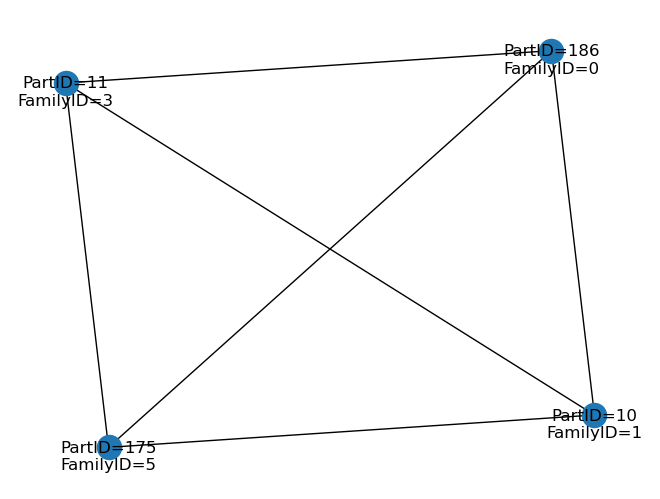

In [416]:
testing_list = []

for graph in validation_set:
    parts = create_part_list(graph)
    partList = []
    for part in parts:
        partList.append((part[0], int(part[1])))
    testing_list.append(partList)

gcn_model = GCNEncoderModel()
predicted_graph = gcn_model.predict_graph(testing_list[example_graph])
predicted_graph.draw()

## 3.2. Initialize the GAE

In [326]:
# Initialize GAE
encoder = GCNEncoderModel(input_dim, hidden_dim, latent_dim)
model = GAE(encoder)

## 3.4. Training

For link prediction, the GAE minimizes the binary cross-entropy loss between the reconstructed edges and the ground-truth edges.

### 3.3.1 Data Loader to batch Graph-Data Objects

In [327]:
# Create a DataLoader for batching the graphs
batch_size = 32  # Adjust based on your GPU memory
loader = DataLoader(all_graph_data, batch_size=batch_size, shuffle=True)

In [328]:
# Prepare optimizer
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

# Define the training loop
def train(model, loader, optimizer):

    model.train()           # Set model to train mode
    total_loss = 0

    for batch in loader:

        # Reset gradients
        optimizer.zero_grad()

        # Encode node features into latent space
        z = model.encode(batch.x, batch.edge_index)

        # Decode and compute reconstruction loss
        loss = model.recon_loss(z, batch.edge_index)

        # Backpropagation and optimization
        loss.backward()
        optimizer.step()

        total_loss += loss.item()

    return total_loss / len(loader)

In [329]:
for epoch in range(gae_epochs):
    loss = train(model, loader, optimizer)
    print(f"Epoch {epoch+1}/{gae_epochs}, Loss: {loss:.4f}")

Epoch 1/100, Loss: 1.0464
Epoch 2/100, Loss: 0.9318
Epoch 3/100, Loss: 0.9231
Epoch 4/100, Loss: 0.9248
Epoch 5/100, Loss: 0.9303
Epoch 6/100, Loss: 0.9168
Epoch 7/100, Loss: 0.9271
Epoch 8/100, Loss: 0.9235
Epoch 9/100, Loss: 0.9234
Epoch 10/100, Loss: 0.9247
Epoch 11/100, Loss: 0.9204
Epoch 12/100, Loss: 0.9256
Epoch 13/100, Loss: 0.9295
Epoch 14/100, Loss: 0.9288
Epoch 15/100, Loss: 0.9273
Epoch 16/100, Loss: 0.9258
Epoch 17/100, Loss: 0.9288
Epoch 18/100, Loss: 0.9294


KeyboardInterrupt: 

# 5. Predict Graph

## 5.1. Initialize Empty Graph with Part_IDs

## 5.2. Iterative Edge Prediction

## 5.3. Output Predicted Graph

# 6. Evaluate Model

## 6.1. Evaluation Metrics

### 6.1.1 Create Testing List

In [369]:
testing_list = []

for graph in validation_set:
    parts = create_part_list(graph)
    partList = []
    for part in parts:
        partList.append(int(part[1]))
    testing_list.append(partList)

print(len(testing_list))
print(testing_list[example_graph])

11159
[175, 186, 175, 10, 11, 11]


### 6.1.2 Test Prediction

In [377]:
gcn_model = GCNEncoderModel()
predicted_graph = gcn_model.predict_graph(testing_list[example_graph])
predicted_graph.draw()

AttributeError: 'Graph' object has no attribute 'add_node'

In [ ]:
from evaluation import evaluate

graph_builder = GCNEncoderModel(training_set)
accuracy = evaluate(graph_builder, testing_list)
print("Accuracy of NeighbourGraphPredictionModel: ", accuracy)

## 6.2. Visualizations